# Este notebook es para analizar los titulares de la página del tiempo

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from wordcloud import WordCloud

from utils import *


## Ingreso a la página web y extracción de los titulares

In [2]:
driver = webdriver.Chrome()
driver.get('https://www.eltiempo.com/')

titulos = []
try:
    titulares = WebDriverWait(driver, 20).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'h3 a'))
    )
    for titular in titulares:
            if titular.text != '':
                titulos.append(titular.text.strip().split('\n')[0])

finally:
    driver.quit()

In [3]:
with open('titulares.txt', 'r', encoding='utf-8') as f:
    titulares_guardados = f.readlines()

titulares_guardados = [titular.strip() for titular in titulares_guardados]

In [4]:
with open('titulares.txt', 'w', encoding='utf-8') as f:
    for titulo in set(titulares_guardados):
        f.write(titulo + '\n')

    for titulo in titulos:
        if titulo not in titulares_guardados:
           f.write(titulo + '\n')

## Limpieza del texto

In [5]:
with open('titulares.txt', 'r', encoding='utf-8') as f:
    titulares = f.readlines()

titulares = [titular.strip() for titular in titulares]

In [6]:
titulares = Texto(textos = titulares, palabras_parada=['vivo', 'video'])

In [7]:
df = pd.DataFrame({
    'titular': titulares.textos,
    'titular_limpio': titulares.textos_limpios
})
df.head()

,titular,titular_limpio
0,Serena Williams fue operada para extirpar un t...,serena williams operada extirpar tumor cuello ...
1,Así es la Ley de Enemigos Extranjeros que Trum...,enemigos extranjeros trump quiere usar deporta...
2,La madre de tres hijos con tumores en los pulm...,madre tres hijos tumores pulmones dieron pocos...
3,"Leire Martínez, vocalista reemplazo de Amaia M...",leire martinez vocalista reemplazo amaia monte...
4,"Lorelei Tarón, esposa de Falcao, habla del pre...",lorelei taron esposa falcao habla precio fama ...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   titular         413 non-null    object
 1   titular_limpio  413 non-null    object
dtypes: object(2)
memory usage: 6.6+ KB


## Análisis de palabras más comunes y nube de palabras

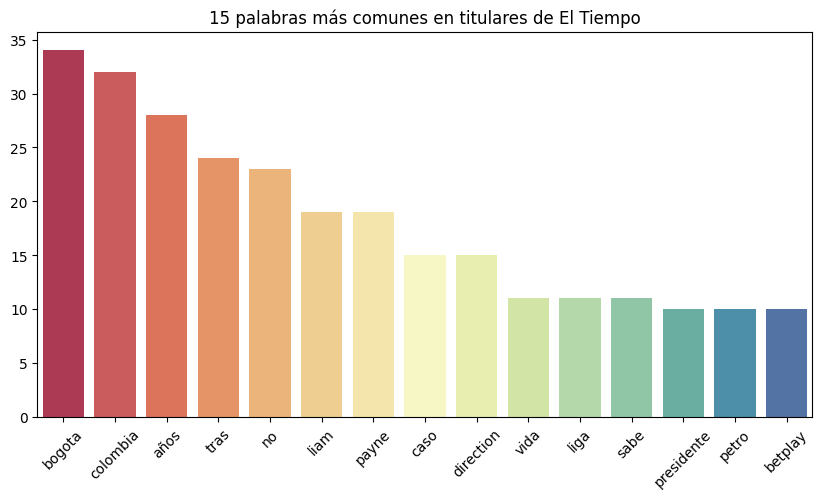

In [9]:
# Palabras más comunes
palabras_comunes = titulares.palabras_mas_comunes(n_palabras=15, plot=True)

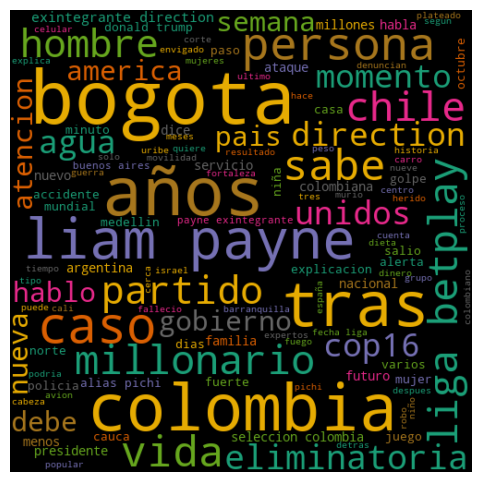

In [10]:
wordcloud = WordCloud(width=500, 
                      height=500, 
                      max_font_size=80, 
                      max_words=120, 
                      background_color='black', 
                      colormap='Dark2_r').generate(titulares.union_textos)

plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Modelos de Topic Modeling

In [11]:
corpus = titulares.corpus
corpus_tfidf = titulares.corpus_tfidf
dictionary = titulares.diccionario
doc_tok = titulares.doc_tok(titulares.textos_limpios)

### LSI

In [12]:
modelo_corpus_lsi = finding_model(corpus, dictionary, doc_tok, True, 12, min_topics=4)
modelo_tfidf_lsi = finding_model(corpus_tfidf, dictionary, doc_tok, True, 12, min_topics=4)

print(modelo_corpus_lsi)
print(modelo_tfidf_lsi)

(9, 0.45232933565276984)
(7, 0.4184954653989177)


### LDA

In [14]:
modelo_corpus_lda = finding_model(corpus, dictionary, doc_tok, False, 12, min_topics=4)
modelo_tfidf_lda = finding_model(corpus_tfidf, dictionary, doc_tok, False, 12, min_topics=4)

print(modelo_corpus_lda)
print(modelo_tfidf_lda)

(6, 0.6053568770802075)
(10, 0.6573588247129377)


### Análisis para el mejor modelo de LSI

In [15]:
if modelo_corpus_lsi[1] > modelo_tfidf_lsi[1]:
    lsi_model = LsiModel(corpus=corpus, num_topics=modelo_corpus_lsi[0], id2word=dictionary)
else:
    lsi_model = LsiModel(corpus=corpus_tfidf, num_topics=modelo_tfidf_lsi[0], id2word=dictionary)

for i in lsi_model.print_topics():
    print(i)

(0, '0.497*"liam" + 0.497*"payne" + 0.418*"direction" + 0.205*"exintegrante" + 0.186*"tras" + 0.177*"murio" + 0.165*"aires" + 0.165*"buenos" + 0.132*"años" + 0.125*"argentina"')
(1, '-0.559*"colombia" + -0.356*"bogota" + -0.323*"no" + -0.201*"tras" + -0.198*"chile" + -0.161*"años" + -0.154*"eliminatoria" + -0.150*"seleccion" + -0.134*"partido" + 0.119*"payne"')
(2, '-0.683*"bogota" + 0.417*"colombia" + 0.153*"chile" + 0.128*"eliminatoria" + -0.123*"agua" + -0.120*"caso" + -0.116*"minuto" + 0.114*"seleccion" + -0.098*"puente" + 0.094*"partido"')
(3, '0.731*"años" + 0.198*"no" + -0.192*"colombia" + -0.169*"bogota" + 0.147*"hombre" + 0.108*"caso" + 0.097*"vida" + -0.092*"eliminatoria" + -0.088*"chile" + -0.083*"tras"')
(4, '-0.519*"liga" + -0.482*"betplay" + -0.278*"millonarios" + -0.226*"fecha" + -0.208*"america" + -0.176*"fortaleza" + -0.146*"envigado" + 0.139*"no" + -0.127*"juego" + -0.120*"nacional"')
(5, '-0.615*"tras" + -0.266*"petro" + 0.215*"bogota" + -0.211*"presidente" + -0.171*

In [16]:
# un titular se asisganará al tema con mayor peso (influencia)
temas_lsi = []
for doc in corpus:
    topic_distribution = lsi_model[doc]
    dominant_topic = max(topic_distribution, key=lambda x: abs(x[1]))
    temas_lsi.append(dominant_topic[0])

df['tema_lsi'] = temas_lsi

### Análisis para el mejor modelo de LDA

In [17]:
if modelo_corpus_lda[1] > modelo_tfidf_lda[1]:
    lda_model = LdaModel(corpus=corpus, num_topics=modelo_corpus_lda[0], id2word=dictionary)
else:
    lda_model = LdaModel(corpus=corpus_tfidf, num_topics=modelo_tfidf_lda[0], id2word=dictionary)

for i in lda_model.print_topics():
    print(i)

(0, '0.004*"bogota" + 0.004*"agua" + 0.003*"adictos" + 0.003*"octubre" + 0.003*"ganar" + 0.003*"claves" + 0.003*"colombia" + 0.003*"jueves" + 0.003*"liam" + 0.003*"payne"')
(1, '0.004*"pichi" + 0.004*"menos" + 0.003*"mañana" + 0.003*"bogota" + 0.003*"veces" + 0.003*"recluido" + 0.003*"domicilio" + 0.003*"coexistencia" + 0.003*"presidencial" + 0.003*"fuero"')
(2, '0.003*"nadaismo" + 0.003*"no" + 0.003*"multa" + 0.002*"vocacion" + 0.002*"dureza" + 0.002*"colegas" + 0.002*"leccion" + 0.002*"casanare" + 0.002*"uribe" + 0.002*"gracioso"')
(3, '0.005*"años" + 0.003*"ecopetrol" + 0.003*"cop16" + 0.003*"nacional" + 0.003*"desarrollado" + 0.003*"mecanica" + 0.003*"brechas" + 0.003*"biopirateria" + 0.002*"pais" + 0.002*"forestal"')
(4, '0.003*"allende" + 0.003*"petro" + 0.003*"tras" + 0.003*"conmovidos" + 0.003*"naciones" + 0.003*"emocionados" + 0.003*"unidas" + 0.003*"rejas" + 0.002*"cuenta" + 0.002*"paso"')
(5, '0.004*"todossomosvoragine" + 0.004*"bogota" + 0.004*"inicio" + 0.003*"direction" +

In [18]:
temas_lda = []
for i, doc in enumerate(corpus):
    topic_distribution = lda_model.get_document_topics(doc)
    dominant_topic = max(topic_distribution, key=lambda x: x[1])
    temas_lda.append(dominant_topic[0])

df['tema_lda'] = temas_lda


## Análisis para los resultados de aplicar lsi y lda

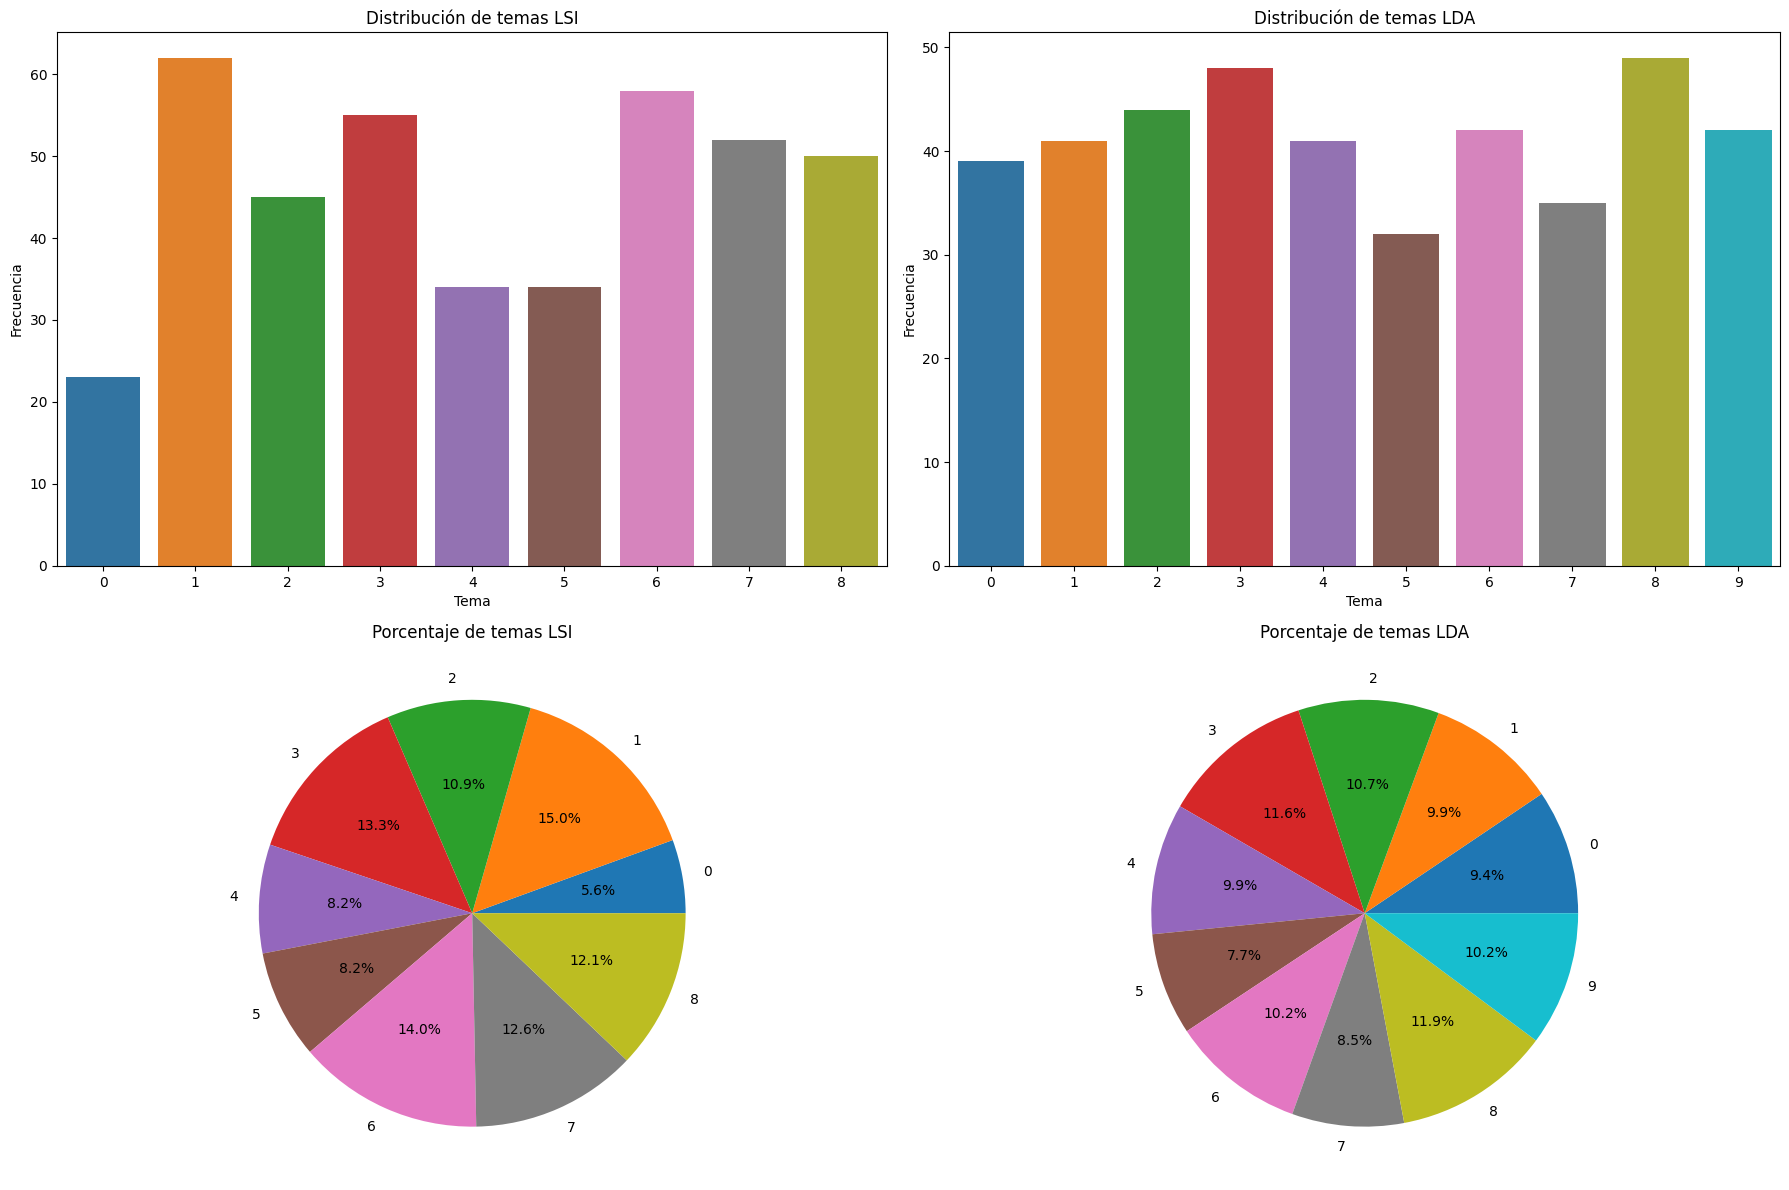

In [19]:
# Visualización de la cantidad de temas
temas_lsi = df['tema_lsi'].value_counts().reset_index().sort_values('tema_lsi', ascending=True)
temas_lda = df['tema_lda'].value_counts().reset_index().sort_values('tema_lda', ascending=True)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

sns.barplot(data=temas_lsi, x="tema_lsi", y='count', palette='tab10', ax=axes[0][0])
axes[0][0].set_title('Distribución de temas LSI')
axes[0][0].set_xlabel('Tema')
axes[0][0].set_ylabel('Frecuencia')

sns.barplot(data=temas_lda, x="tema_lda", y='count', palette='tab10', ax=axes[0][1])
axes[0][1].set_title('Distribución de temas LDA')
axes[0][1].set_xlabel('Tema')
axes[0][1].set_ylabel('Frecuencia')

axes[1][0].pie(temas_lsi['count'], labels=temas_lsi['tema_lsi'], autopct='%1.1f%%')
axes[1][0].set_title('Porcentaje de temas LSI')

axes[1][1].pie(temas_lda['count'], labels=temas_lda['tema_lda'], autopct='%1.1f%%')
axes[1][1].set_title('Porcentaje de temas LDA')

plt.tight_layout()
plt.show()

## Guardar los temas por titular en un txt

In [20]:
temas = df.sort_values('tema_lsi')

with open(r'Division por topicos\temas_lsi.txt', 'w', encoding='utf-8') as f:
    for i in range(len(temas['tema_lsi'].unique())):
        f.write(f'Tema {i}:\n')
        f.write(f'{lsi_model.print_topic(i, topn=8)}\n')
        f.write('------------------------------------\n')
        for titular in temas[temas['tema_lsi'] == i]['titular']:
            f.write(titular + '\n')
        f.write('\n\n')

In [21]:
temas = df.sort_values('tema_lda')
f
with open(r'Division por topicos\temas_lda.txt', 'w', encoding='utf-8') as f:
    for i in range(len(temas['tema_lda'].unique())):
        f.write(f'Tema {i}:\n')
        f.write(f'{lda_model.print_topic(i, topn=8)}\n')
        f.write('------------------------------------\n')
        for titular in temas[temas['tema_lda'] == i]['titular']:
            f.write(titular + '\n')
        f.write('\n\n')